# CAD Challenge 1: Binary classification

## Set things up

### Imports

In [3]:
from skimage.color import  rgb2hsv,  rgb2lab, rgb2yuv
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from skimage import io
import numpy as np
import os.path
import os

import pickle

from dask.distributed import Client
import pandas as pd

### Set dataset location

In [4]:
parent_path = os.path.dirname(os.getcwd())

with open(parent_path + '\\dataset_path.txt', 'r') as file:
    dataset_path = file.read().strip()  # Use strip() to remove leading/trailing whitespace

### Set up matplotlib

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
#%matplotlib widget

Text(0.5, 1.0, 'Other image')

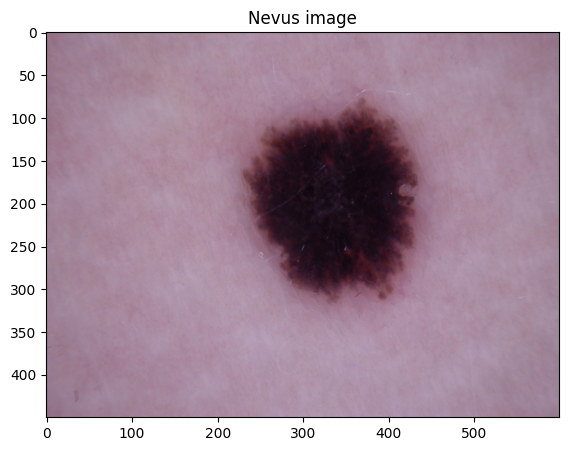

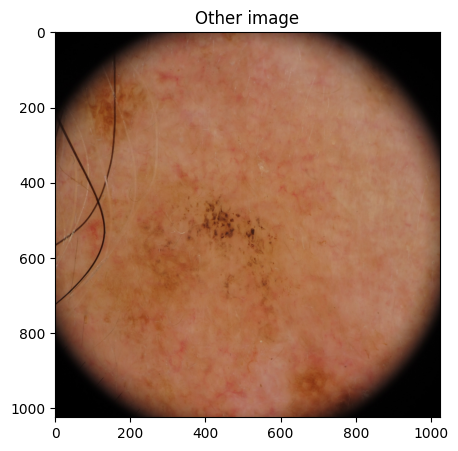

In [6]:
nevus_path = os.path.join(dataset_path, 'train\\nevus')
others_path = os.path.join(dataset_path, 'train\\others')

# get the filenames of all the nevus images in the training dataset
nevus_filenames = os.listdir(nevus_path)

# get the filenames of all the other images in the training dataset 
others_filenames = os.listdir(others_path)

# load the first nevus image
nevus_image = io.imread(os.path.join(nevus_path, nevus_filenames[0]))

# load the first other image
others_image = io.imread(os.path.join(others_path, others_filenames[4]))

plt.figure()
plt.imshow(nevus_image)
plt.title('Nevus image')

plt.figure()
plt.imshow(others_image)
plt.title('Other image')

# Image Descriptors

## Color Features

In [56]:
## TODO: Open the image in 6 diferent color spaces with skimage

def set_colorspace(img, colorspace='rgb'):

    if colorspace == 'rgb':
        return img
    elif colorspace == 'hsv':
        img = rgb2hsv(img)
        # img[:, :, 0] /= 360.0
        return img
    elif colorspace == 'lab':
        img = rgb2lab(img)
        # img[:, :, 0] /= 100.0
        return img
    elif colorspace == 'yuv':
        img = rgb2yuv(img)
        # img[:, :, 0] /= 1.0 
        return img
    else:
        raise Exception('invalid colorspace')


def colorHistogram(img, color_space='rgb', bins=[256,256,256], plot=False):

    if plot:
        colors = ['tab:orange', 'tab:purple', 'tab:cyan']
        fig, ax = plt.subplots(2,3, constrained_layout=True)    
    
    histograms = []

    for ci, c in enumerate(color_space):

        b = bins[ci]
        histogram = np.histogram(img[:,:,ci].flatten(), bins=b)

        if plot:
            ax[0,ci].imshow(img[:,:,ci], cmap='gray')

            ax[1,ci].bar(histogram[1][:-1], histogram[0], width=1,color=colors[ci])
            #add subplot title
            ax[1,ci].set_title(c.upper() + ' channel histogram')

        histograms.append(histogram)


    return histograms



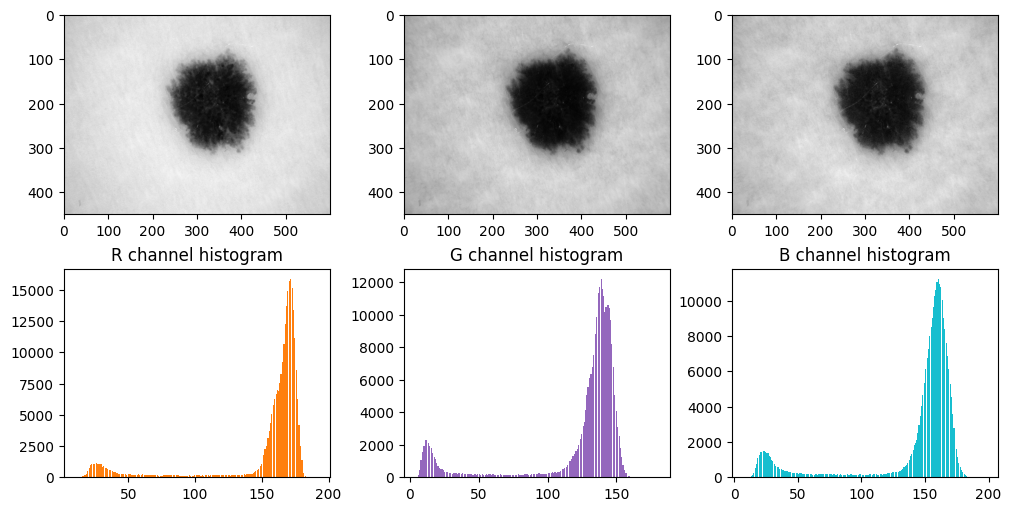

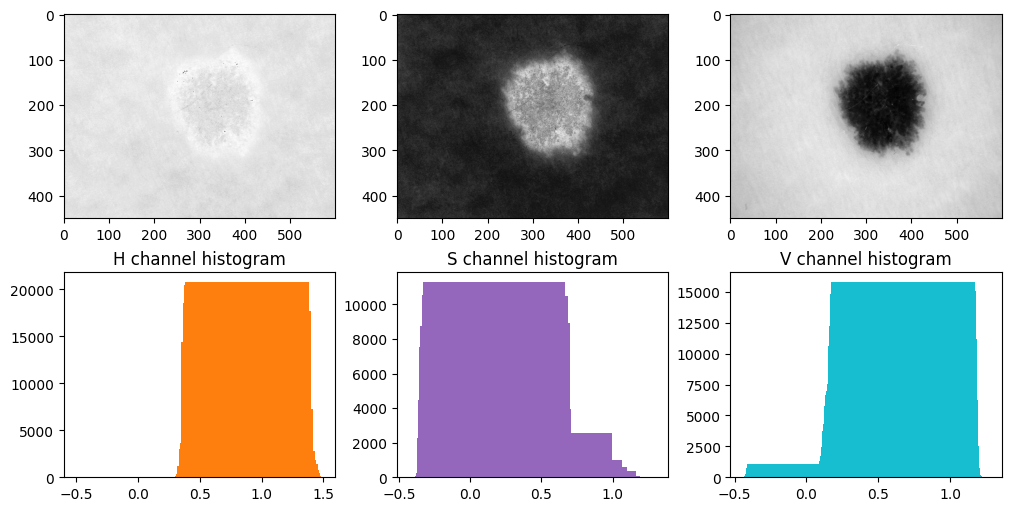

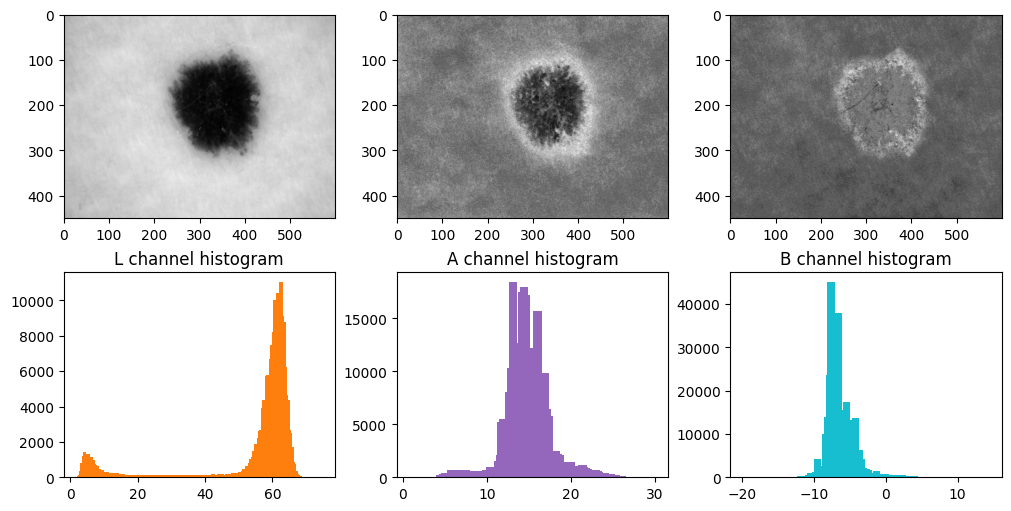

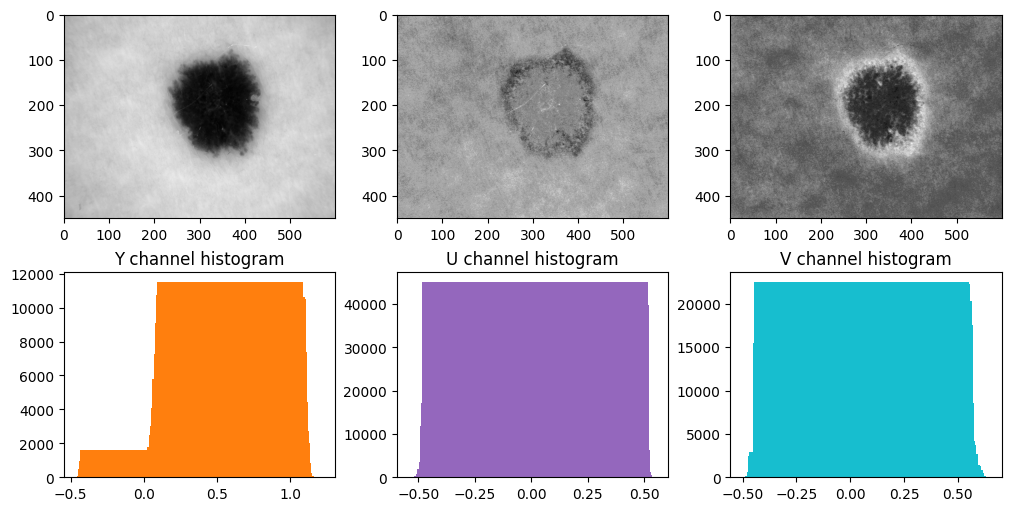

In [8]:
color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# Bin sizes for each color space
# Bins are used to discretize the values of each channel
bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
}

for cs in color_spaces:
    img_cs = set_colorspace(nevus_image, cs)
    h = colorHistogram(img_cs, cs, bins[cs], plot=True)

In [9]:
# check the optimal number of bins for each color space and channel using the Freedman-Diaconis rule

# load the first nevus image
image = io.imread(os.path.join(nevus_path, nevus_filenames[1000]))
# load the first other image
# image = io.imread(os.path.join(others_path, others_filenames[4]))

cs = ['rgb', 'hsv', 'lab', 'yuv']
bins = {}
for color_space in cs:
    bins_cs = []
    image_cs = set_colorspace(image, color_space)
    for i in range(image.shape[2]):
        bins_cs.append(np.histogram_bin_edges(image_cs[:,:,i], bins='fd').shape[0] - 1)

    bins[color_space] = bins_cs

print(bins)

{'rgb': [1209, 650, 499], 'hsv': [733, 646, 1222], 'lab': [813, 409, 405], 'yuv': [773, 375, 277]}


In [10]:
# # # Choose the color space to use
# # color_space = "RGB"


# # # Convert the image to the desired color space
# # if color_space == "RGB":
# #     image_cs = image
# # elif color_space == "YUV":
# #     image_cs = color.rgb2yuv(image)
# # elif color_space == "HSV":
# #     image_cs = color.rgb2hsv(image)
# # elif color_space == "LAB":
# #     image_cs = color.rgb2lab(image)
# # else:
# #     raise ValueError("Invalid color space")

# color_space = 'rgb'

# image_cs = set_colorspace(image, 'rgb')

# # Initialize an empty dictionary to store the histogram values
# hist = {}

# print(image_cs.shape)
# # Loop through each channel of the image
# for i in range(image_cs.shape[2]):
#     # Calculate the bin edges for the current channel using np.histogram_bin_edges and the chosen algorithm
#     bin_edges = np.histogram_bin_edges(image_cs[:,:,i], bins='fd')
    
#     print(bin_edges.shape)
#     # Calculate the histogram for the current channel using np.histogram and the bin edges
#     hist_values, hist_edges = np.histogram(image_cs[:,:,i], bins=450, density=True)

#     print(hist_values.shape)
#     print(hist_edges.shape)

#     # plot the histogram
#     plt.figure()
#     plt.bar(hist_edges[:-1], hist_values, width=1)
#     plt.xlabel('Bin edges')
#     plt.ylabel('Histogram values')
#     plt.title('Histogram')
#     plt.show()
    

#     # Loop through each bin and create a key with the channel and bin number
#     for j in range(len(hist_values)):
#         # Append the histogram value to the dictionary with the key as color_space_channel_bin
#             hist[color_space + "_" + color_space[i] + "_" + str(j+1)] = hist_values[j] # Use single value instead of array

# # Print the histogram values
# print(hist)



In [11]:
# Import the required modules
import numpy as np
import skimage
from skimage import io, color
import pandas as pd # Import pandas

# Read the input image as a numpy array
image = nevus_image

# Define a function to calculate the histogram for a given color space and number of bins
def histogram(image, color_space, bins):
    # Convert the image to the desired color space
    if color_space == "RGB":
        image_cs = image
    elif color_space == "YUV":
        image_cs = color.rgb2yuv(image)
    elif color_space == "HSV":
        image_cs = color.rgb2hsv(image)
    elif color_space == "LAB":
        image_cs = color.rgb2lab(image)
    else:
        raise ValueError("Invalid color space")
    
    # Initialize an empty dictionary to store the histogram values
    hist = {}
    
    print(image_cs.shape)
    # Loop through each channel of the image
    for i in range(image_cs.shape[2]):
        # Calculate the bin edges for the current channel using np.histogram_bin_edges and the chosen algorithm
        bin_edges = np.histogram_bin_edges(image_cs[:,:,i], bins=algorithm)
        
        # Calculate the histogram for the current channel using np.histogram and the bin edges
        hist_values, hist_edges = np.histogram(image_cs[:,:,i], bins=bin_edges, range=(0,1), density=True)
        
        # Loop through each bin and create a key with the channel and bin number
        for j in range(len(hist_values)):
            # Append the histogram value to the dictionary with the key as color_space_channel_bin
            hist[color_space + "_" + color_space[i] + "_" + str(j+1)] = hist_values[j] # Use single value instead of array
    
    # Return the histogram dictionary
    return hist

# Choose an algorithm to calculate the optimal number of bins, e.g., "sturges"
algorithm = "fd"

# Initialize an empty dictionary to store the 1D feature vector
features = []

# Loop through each color space
for cs in ["RGB", "YUV", "HSV", "LAB"]:
    # Calculate the histogram for the current color space and append it to the feature dictionary
    features.append(histogram(image, cs, bins))

# Print the feature dictionary
print(features)

# Create a pandas dataframe from the feature dictionary
df = pd.DataFrame(data=features) # Pass feature as data and image name as index

# Print the dataframe
print(df)

(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
(450, 600, 3)
[{'RGB_R_1': 9.208103130755049e-06, 'RGB_R_2': 0.0, 'RGB_R_3': 0.0, 'RGB_R_4': 0.0, 'RGB_R_5': 0.00010128913443830554, 'RGB_R_6': 0.0, 'RGB_R_7': 0.0, 'RGB_R_8': 0.00017495395948434591, 'RGB_R_9': 0.0, 'RGB_R_10': 0.0003222836095764267, 'RGB_R_11': 0.0, 'RGB_R_12': 0.0, 'RGB_R_13': 0.0006077348066298332, 'RGB_R_14': 0.0, 'RGB_R_15': 0.0007366482504604072, 'RGB_R_16': 0.0, 'RGB_R_17': 0.0, 'RGB_R_18': 0.001740331491712712, 'RGB_R_19': 0.0, 'RGB_R_20': 0.0027348066298342614, 'RGB_R_21': 0.0, 'RGB_R_22': 0.0, 'RGB_R_23': 0.004567219152854484, 'RGB_R_24': 0.0, 'RGB_R_25': 0.006878453038673991, 'RGB_R_26': 0.0, 'RGB_R_27': 0.0, 'RGB_R_28': 0.008692449355432804, 'RGB_R_29': 0.0, 'RGB_R_30': 0.009972375690607674, 'RGB_R_31': 0.0, 'RGB_R_32': 0.0, 'RGB_R_33': 0.010119705340699843, 'RGB_R_34': 0.0, 'RGB_R_35': 0.009981583793738516, 'RGB_R_36': 0.0, 'RGB_R_37': 0.0, 'RGB_R_38': 0.010193370165745794, 'RGB_R_39': 0.0, 'RGB_R_40': 0.0101104972

c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:326: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


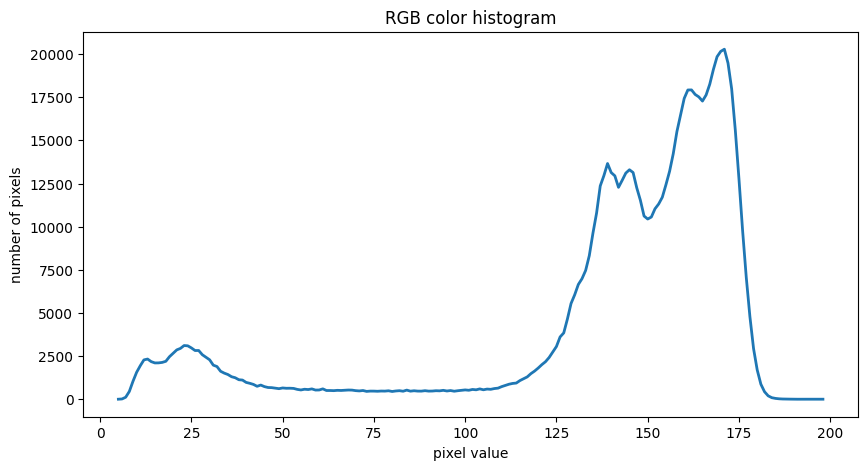

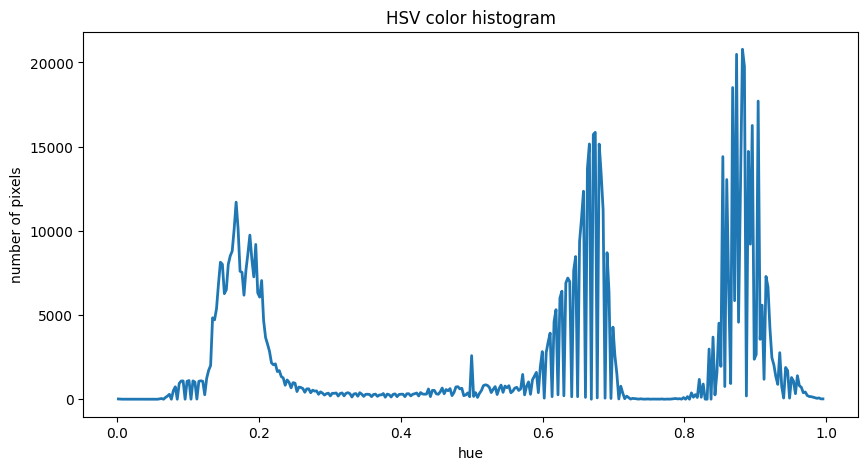

In [12]:
# Import the required libraries
import numpy as np
import pandas as pd
from skimage.exposure import histogram

# Read the image file
img = nevus_image

# compute and plot RGB color histogram
hist, hist_centers = histogram(img, nbins=256)

# plot the histogram
plt.figure()
plt.title('RGB color histogram')
plt.xlabel('pixel value')
plt.ylabel('number of pixels')
plt.plot(hist_centers, hist, lw=2)

# compute and plot HSV color histogram
img_hsv = rgb2hsv(img)
hist_hsv, hist_centers_hsv = histogram(img_hsv, nbins=360)

# plot the histogram
plt.figure()
plt.title('HSV color histogram')
plt.xlabel('hue')
plt.ylabel('number of pixels')
plt.plot(hist_centers_hsv, hist_hsv, lw=2)

In [13]:
# rgb color space represents an image as a 3D array of red, green, and blue channels
# each channel is a 2D array of pixel values ranging from 0 to 255

# hsv color space represents an image as a 3D array of hue, saturation, and value channels
# hue is the color, saturation is the amount of color, and value is the brightness of the color
# each channel is a 2D array of pixel values ranging from 0 to 1

# lab color space represents an image as a 3D array of lightness, a, and b channels
# lightness is the brightness of the color, a is the green-red channel, and b is the blue-yellow channel
# each channel is a 2D array of pixel values ranging from 0 to 1

# yuv color space represents an image as a 3D array of luminance, u, and v channels
# luminance is the brightness of the color, u is the blue-luminance channel, and v is the red-luminance channel
# each channel is a 2D array of pixel values ranging from 0 to 1

In [14]:
# color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# # Bin sizes for each color space
# # Bins are used to discretize the values of each channel
# bins = {
#     'rgb': [256, 256, 256],
#     'hsv': [360, 256, 256],
#     'lab': [256, 128, 128],
#     'yuv': [256, 128, 128]
# }

# def extract_features(filename, input_path, output_path, color_spaces, bins):
#     img = io.imread(input_path)

#     features = {}

#     features['filename'] = filename

#     # create dictionary entries for each color space histogram
#     for cs in color_spaces:
#         img_cs = set_colorspace(img, cs)
#         features[cs] = colorHistogram(img_cs, cs, bins[cs])

#     # save pikle file
#     with open(output_path, 'wb') as f:
#         pickle.dump(features, f)

#     return features

In [40]:
print(nevus_filenames[0].split('.')[0])

# # remove 3 first letters and convert to int
# int(nevus_filenames[0][3:-4])

nev00001


In [85]:
color_spaces = ['rgb', 'hsv', 'lab', 'yuv']

# Bin sizes for each color space
# Bins are used to discretize the values of each channel
bins = {
    'rgb': [256, 256, 256],
    'hsv': [360, 256, 256],
    'lab': [256, 128, 128],
    'yuv': [256, 128, 128]
}

def extract_features(filename, input_path, output_path, color_spaces, bins):
    img = io.imread(input_path)

    features = {}

    features['filename'] = filename.split('.')[0]

    features['type'] = 'nevus' if 'nev' in filename else 'other'

    features['label'] = 0 if 'nev' in filename else 1

    # create dictionary entries for each color space histogram
    for cs in color_spaces:
        print(cs)
        img_cs = set_colorspace(img, cs)

        # loop through each channel of the image
        for i in range(image_cs.shape[2]):
             # calculate the histogram for the current channel using np.histogram and the number of bins
            hist_values, _ = np.histogram(img_cs[:,:,i], bins=bins[cs][i], density=False)

            print(hist_values.shape)
        
            # Loop through each bin and create a key with the channel and bin number
            for j in range(len(hist_values)):
                # Append the histogram value to the dictionary with the key as color_space_channel_bin
                features[cs + "_" + cs[i] + "_" + str(j+1)] = hist_values[j] # Use single value instead of array

    # # save pikle file
    # with open(output_path, 'wb') as f:
    #     pickle.dump(features, f)

    print(features)

    return features

In [76]:
color_spaces

['rgb', 'hsv', 'lab', 'yuv']

In [86]:
out = extract_features(nevus_filenames[0], os.path.join(nevus_path, nevus_filenames[0]), 'test.pkl', color_spaces, bins)

rgb
(256,)
(256,)
(256,)
hsv
(360,)
(256,)
(256,)
lab
(256,)
(128,)
(128,)
yuv
(256,)
(128,)
(128,)
{'filename': 'nev00001', 'type': 'nevus', 'label': 0, 'rgb_r_1': 1, 'rgb_r_2': 0, 'rgb_r_3': 11, 'rgb_r_4': 0, 'rgb_r_5': 19, 'rgb_r_6': 35, 'rgb_r_7': 0, 'rgb_r_8': 66, 'rgb_r_9': 80, 'rgb_r_10': 189, 'rgb_r_11': 0, 'rgb_r_12': 297, 'rgb_r_13': 496, 'rgb_r_14': 0, 'rgb_r_15': 747, 'rgb_r_16': 944, 'rgb_r_17': 1083, 'rgb_r_18': 0, 'rgb_r_19': 1099, 'rgb_r_20': 1084, 'rgb_r_21': 0, 'rgb_r_22': 1107, 'rgb_r_23': 1098, 'rgb_r_24': 0, 'rgb_r_25': 1039, 'rgb_r_26': 1036, 'rgb_r_27': 1028, 'rgb_r_28': 0, 'rgb_r_29': 855, 'rgb_r_30': 878, 'rgb_r_31': 0, 'rgb_r_32': 770, 'rgb_r_33': 718, 'rgb_r_34': 656, 'rgb_r_35': 0, 'rgb_r_36': 577, 'rgb_r_37': 570, 'rgb_r_38': 0, 'rgb_r_39': 496, 'rgb_r_40': 435, 'rgb_r_41': 0, 'rgb_r_42': 420, 'rgb_r_43': 357, 'rgb_r_44': 331, 'rgb_r_45': 0, 'rgb_r_46': 258, 'rgb_r_47': 299, 'rgb_r_48': 0, 'rgb_r_49': 269, 'rgb_r_50': 271, 'rgb_r_51': 251, 'rgb_r_52': 0, 'r

In [87]:
# df
df = pd.DataFrame(data=out, index=[0])

In [88]:
df.shape

(1, 2667)

In [84]:
df.head()

,filename,type,label,rgb_r_1,rgb_r_2,rgb_r_3,rgb_r_4,rgb_r_5,rgb_r_6,rgb_r_7,...,yuv_v_119,yuv_v_120,yuv_v_121,yuv_v_122,yuv_v_123,yuv_v_124,yuv_v_125,yuv_v_126,yuv_v_127,yuv_v_128
0,nev00001,nevus,0,0.000005,0.0,0.000058,0.0,0.0001,0.000183,0.0,...,0.0,0.0,0.003203,0.035232,0.006406,0.0,0.028826,0.006406,0.0,0.006406


In [15]:

client = Client(n_workers=1, threads_per_worker=512)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 512,Total memory: 63.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56945,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 512
Started: Just now,Total memory: 63.85 GiB
Comm: tcp://127.0.0.1:56954,Total threads: 512
Dashboard: http://127.0.0.1:56955/status,Memory: 63.85 GiB
Nanny: tcp://127.0.0.1:56948,


In [16]:


futures_nevus = []

for filename in nevus_filenames:

    input_path = os.path.join(nevus_path, filename)

    output_path = dataset_path + '\\features\\nevus\\' + filename.split('.')[0] + '.pkl'

    # check if the file already exists
    if os.path.isfile(output_path):
        continue

    future = extract_features(filename, output_path, color_spaces, bins)
    futures_nevus.append(future)

results_nevus = client.gather(futures_nevus)



futures_others = []

for filename in others_filenames:

    input_path = os.path.join(others_path, filename)

    output_path = dataset_path + '\\features\\others\\' + filename.split('.')[0] + '.pkl'

    # check if the file already exists
    if os.path.isfile(output_path):
        continue

    future = extract_features(filename, input_path, output_path, color_spaces, bins)
    futures_others.append(future)

results_others = client.gather(futures_others)


client.close()

In [17]:
# load all the features from the pickle files
nevus_features = []
for filename in nevus_filenames:
    with open(dataset_path + '\\features\\nevus\\' + filename.split('.')[0] + '.pkl', 'rb') as f:
        nevus_features.append(pickle.load(f))

others_features = []
for filename in others_filenames:
    with open(dataset_path + '\\features\\others\\' + filename.split('.')[0] + '.pkl', 'rb') as f:
        others_features.append(pickle.load(f))

# create df with all the features
df_nevus = pd.DataFrame(nevus_features)
df_others = pd.DataFrame(others_features)

In [18]:
# add label column
df_nevus['label'] = 0
df_others['label'] = 1

# concatenate the two dataframes
df = pd.concat([df_nevus, df_others], ignore_index=True)

In [31]:
df.head()
df_others.head()

,filename,rgb,hsv,lab,yuv,label
0,ack00001.jpg,"[([1, 0, 0, 1, 5, 0, 8, 0, 36, 53, 0, 93, 141,...","[([73294, 1481, 26942, 9455, 25286, 26896, 125...","[([2, 0, 0, 2, 4, 4, 5, 7, 30, 27, 50, 78, 54,...","[([2, 0, 1, 1, 8, 6, 2, 45, 57, 62, 64, 138, 1...",0
1,ack00002.jpg,"[([1, 2, 1, 3, 0, 8, 11, 10, 0, 17, 22, 21, 40...","[([14575, 10441, 7233, 19900, 4975, 6553, 8379...","[([1, 0, 0, 1, 0, 4, 5, 4, 13, 19, 18, 33, 25,...","[([1, 0, 1, 0, 3, 4, 6, 24, 26, 17, 35, 44, 53...",0
2,ack00003.jpg,"[([4, 0, 2, 0, 6, 0, 11, 0, 13, 0, 21, 0, 10, ...","[([4456, 1, 845, 0, 210, 123, 498, 42, 8, 83, ...","[([2, 0, 0, 0, 2, 1, 10, 1, 7, 4, 14, 3, 6, 5,...","[([2, 0, 0, 1, 2, 10, 1, 7, 5, 14, 3, 10, 10, ...",0
3,ack00004.jpg,"[([83290, 54850, 55198, 48776, 21171, 6869, 38...","[([310351, 18499, 22628, 28694, 14129, 14551, ...","[([137845, 54627, 49833, 21515, 10207, 3187, 3...","[([83278, 54584, 54876, 48779, 20558, 7313, 15...",0
4,ack00005.jpg,"[([23254, 38547, 19917, 4645, 2415, 1905, 0, 1...","[([87238, 0, 5, 4, 543, 1037, 142, 258, 512, 2...","[([61852, 21215, 5058, 2453, 2097, 1989, 1667,...","[([23391, 38480, 21181, 1854, 3245, 2432, 1819...",0


In [30]:
df['rgb'][0][3]

IndexError: list index out of range

In [27]:
len(df['rgb'][0][0])

2

c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\_shared\utils.py:326: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


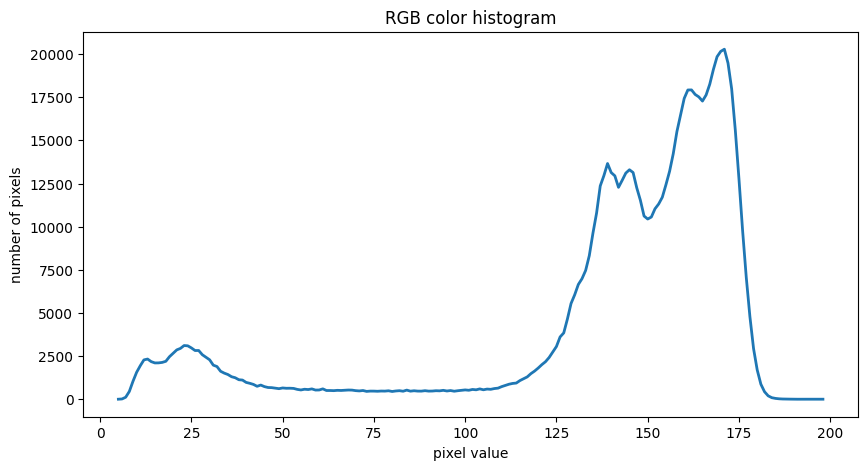

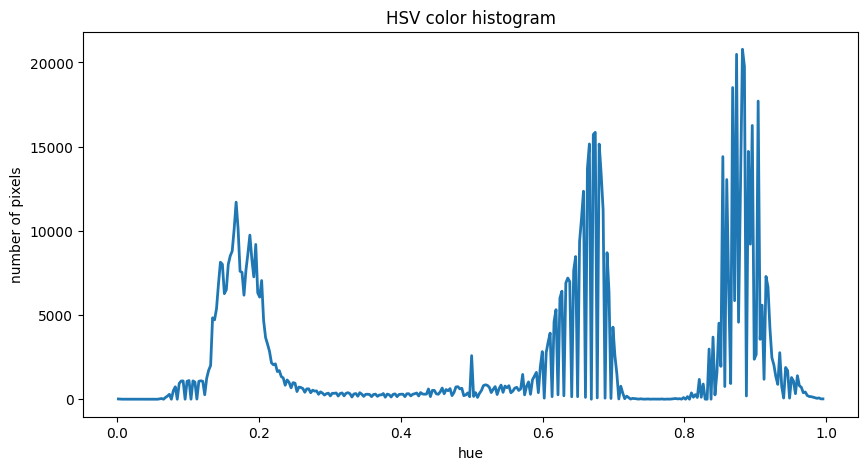

## Texture Features

# Classification

In [13]:
# HalvingRandomSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score


In [28]:
# get 500 of each
df_feat_s = pd.concat([resample(df[df['label'] == 1], n_samples=250, random_state=42),
                     resample(df[df['label'] == 0], n_samples=250, random_state=42)], ignore_index=True)

# drop filename and label columns
y = df_feat_s['label']
df_feat_s_d = df_feat_s.drop(['filename', 'label'], axis=1)

# separate labels from features
X = df_feat_s_d

In [35]:
X

array([[list([(array([104339, 125706,  79541,  35536,      0,  11506,   3275,   2057,
                    0,   1862,   1704,   1652,      0,   1592,   1568,   1491,
                    0,   1558,   1508,   1531,      0,   1526,   1488,   1369,
                 1384,      0,   1367,   1316,   1336,      0,   1247,   1204,
                 1235,      0,   1208,   1245,   1168,      0,   1104,   1092,
                 1019,      0,   1061,   1033,   1009,   1075,      0,   1028,
                  987,   1025,      0,   1017,    983,    980,      0,    926,
                  859,    939,      0,    894,    901,    871,      0,    924,
                  909,    906,    850,      0,    909,    845,    849,      0,
                  868,    831,    807,      0,    847,    822,    893,      0,
                  820,    810,    778,      0,    774,    723,    766,    716,
                    0,    746,    659,    699,      0,    712,    653,    638,
                    0,    629,    610,    709

In [34]:
svm_m = SVC(C = 100, kernel='rbf', gamma = 'scale', probability=True, random_state=42, verbose=True)

# grid search for best parameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': ['scale', 'auto']}
grid_search = HalvingRandomSearchCV(svm_m, param_grid, cv=10, scoring='f1', random_state=42, verbose=True, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

svm_m = grid_search.best_estimator_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 40
max_resources_: 500
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 40
Fitting 10 folds for each of 12 candidates, totalling 120 fits


ValueError: 
All the 120 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
TypeError: float() argument must be a string or a real number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py", line 192, in fit
    X, y = self._validate_data(
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\legor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: setting an array element with a sequence.


In [ ]:
y_pred = cross_val_predict(svm_m, X, y, cv=10, method='predict_proba', verbose=True, n_jobs=-1)[:,1][y.index]

In [ ]:
# plot roc curve
plt.figure()
fpr, tpr, _ = roc_curve(y, y_pred)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# get the roc auc score
print('ROC AUC score:', roc_auc_score(y, y_pred))